# Librairies & Functions

In [3]:
import os 
import numpy as np
from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D, BatchNormalization
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from data import *
from keras.utils import plot_model
import matplotlib.pyplot as plt
import time

smooth = 1e-3 #avoid to divide by 0 in dice_coef function
npy_path = "data/npydata"


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def load_validation_data():
    print('load validation images...')
    imgs_validation = np.load(npy_path+"/validation_volumes.npy")
    imgs_mask_validation = np.load(npy_path+"/validation_labels.npy")
    imgs_validation = imgs_validation.astype('float32')
    imgs_mask_validation = imgs_mask_validation.astype('float32')
    imgs_validation /= 255
    imgs_mask_validation /= 255
    imgs_mask_validation[imgs_mask_validation > 0.5] = 1
    imgs_mask_validation[imgs_mask_validation <= 0.5] = 0
    return imgs_validation,imgs_mask_validation

def load_train_data():
    print('load train images...')
    imgs_train = np.load(npy_path+"/train_volumes.npy")
    imgs_mask_train = np.load(npy_path+"/train_labels.npy")
    imgs_train = imgs_train.astype('float32')
    imgs_mask_train = imgs_mask_train.astype('float32')
    imgs_train /= 255
    imgs_mask_train /= 255
    imgs_mask_train[imgs_mask_train > 0.5] = 1
    imgs_mask_train[imgs_mask_train <= 0.5] = 0
    return imgs_train,imgs_mask_train

def load_test_data():
	print('-'*30)
	print('load test images...')
	print('-'*30)
	imgs_test = np.load(npy_path+"/test_volumes.npy")
	imgs_test = imgs_test.astype('float32')
	imgs_test /= 255
	return imgs_test




class myUnet(object):

	def __init__(self, img_rows = 128, img_cols = 128):

		self.img_rows = img_rows
		self.img_cols = img_cols

	def load_data(self):

		mydata = dataProcess(self.img_rows, self.img_cols)
		imgs_train, imgs_mask_train = load_train_data()
		imgs_validation, imgs_mask_validation = load_validation_data()
		imgs_test = load_test_data()
		return imgs_train, imgs_mask_train, imgs_validation, imgs_mask_validation, imgs_test

	def get_unet(self):

		inputs = Input((self.img_rows, self.img_cols,1))


		conv1 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
		print ("conv1 shape:",conv1.shape)
		conv1 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
		print ("conv1 shape:",conv1.shape)
		#norm1 = BatchNormalization(axis=-1)
		pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
		print ("pool1 shape:",pool1.shape)

		conv2 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
		print ("conv2 shape:",conv2.shape)
		conv2 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
		print ("conv2 shape:",conv2.shape)
		#norm2 = BatchNormalization(axis=-1)
		pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
		print ("pool2 shape:",pool2.shape)

		conv3 = Conv2D(256, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
		print ("conv3 shape:",conv3.shape)
		conv3 = Conv2D(256, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
		print ("conv3 shape:",conv3.shape)
		#norm3 = BatchNormalization(axis=-1)
		pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
		print ("pool3 shape:",pool3.shape)

		conv4 = Conv2D(512, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
		conv4 = Conv2D(512, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
		drop4 = Dropout(0.5)(conv4)
		pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

		conv5 = Conv2D(1024, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
		conv5 = Conv2D(1024, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
		drop5 = Dropout(0.5)(conv5)

		up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
		merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
		conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
		conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

		up7 = Conv2D(256, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
		merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
		conv7 = Conv2D(256, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
		conv7 = Conv2D(256, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

		up8 = Conv2D(128, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
		merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
		conv8 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
		conv8 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

		up9 = Conv2D(64, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
		merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
		conv9 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
		conv9 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
		conv9 = Conv2D(2, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        
		conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

		model = Model(input = inputs, output = conv10)
  
		model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_loss, metrics = [dice_coef])

		return model


	def train(self):

		print("loading data")
		imgs_train, imgs_mask_train, imgs_validation, imgs_mask_validation, imgs_test = self.load_data()
		print("loading data done")
		model = self.get_unet()
		#print(model.summary())
		print("got unet")
        
        # checkpoint
		filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
		model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
		callbacks_list = [model_checkpoint]
		print('Fitting model...')
		history = model.fit(imgs_train, imgs_mask_train, batch_size=4, nb_epoch=130, verbose=1,validation_data=(imgs_validation, imgs_mask_validation), shuffle=True, callbacks=callbacks_list)
		#rint('Fitting model...')
		#history = model.fit(imgs_train, imgs_mask_train, batch_size=1, nb_epoch=5, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

		print(history.history.keys())
		
		# summarize history for accuracy
		plt.plot(history.history['dice_coef'])
		plt.plot(history.history['val_dice_coef'])
		plt.title('model accuracy')
		plt.ylabel('Dice')
		plt.xlabel('epoch')
		plt.legend(['train', 'validation'], loc='upper left')
		plt.show()
		
		# summarize history for loss
		plt.plot(history.history['loss'])
		plt.plot(history.history['val_loss'])
		plt.title('model loss')
		plt.ylabel('loss')
		plt.xlabel('epoch')
		plt.legend(['train', 'validation'], loc='upper left')
		plt.show()
		
		
		
		print('predict test data')
		imgs_mask_test = model.predict(imgs_test, batch_size=1, verbose=1)
		np.save('results/imgs_mask_test.npy', imgs_mask_test)

	def save_img(self):

		print("array to image")
		imgs = np.load('results/imgs_mask_test.npy')
		for i in range(imgs.shape[0]):
			img = imgs[i]
			img = array_to_img(img)
			img.save("results/%d.jpg"%(i))

### Model Summary

In [5]:
mymodel = myUnet()
m = mymodel.get_unet()
m.summary()

conv1 shape: (?, 128, 128, 64)
conv1 shape: (?, 128, 128, 64)
pool1 shape: (?, 64, 64, 64)
conv2 shape: (?, 64, 64, 128)
conv2 shape: (?, 64, 64, 128)
pool2 shape: (?, 32, 32, 128)
conv3 shape: (?, 32, 32, 256)
conv3 shape: (?, 32, 32, 256)
pool3 shape: (?, 16, 16, 256)


D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:166: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
D:\Anaconda3\envs\tensorflow\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:171: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:176: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
D:\Anaconda3\envs\tensorflow\lib\site-packages\ip

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

# Training

loading data
load train images...
load validation images...
------------------------------
load test images...
------------------------------
loading data done
conv1 shape: (?, 128, 128, 64)
conv1 shape: (?, 128, 128, 64)
pool1 shape: (?, 64, 64, 64)
conv2 shape: (?, 64, 64, 128)
conv2 shape: (?, 64, 64, 128)
pool2 shape: (?, 32, 32, 128)
conv3 shape: (?, 32, 32, 256)
conv3 shape: (?, 32, 32, 256)
pool3 shape: (?, 16, 16, 256)


D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:101: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
D:\Anaconda3\envs\tensorflow\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:106: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:111: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
D:\Anaconda3\envs\tensorflow\lib\site-packages\ip

got unet
Fitting model...
Train on 25368 samples, validate on 4477 samples
Epoch 1/130
25368/25368 [==============================] - 988s 39ms/step - loss: 0.1249 - dice_coef: 0.8751 - val_loss: 0.1313 - val_dice_coef: 0.8687

Epoch 00001: val_loss improved from inf to 0.13131, saving model to weights-improvement-01-0.13.hdf5
Epoch 2/130
25368/25368 [==============================] - 986s 39ms/step - loss: 0.0526 - dice_coef: 0.9474 - val_loss: 0.0683 - val_dice_coef: 0.9317

Epoch 00002: val_loss improved from 0.13131 to 0.06827, saving model to weights-improvement-02-0.07.hdf5
Epoch 3/130
25368/25368 [==============================] - 987s 39ms/step - loss: 0.0345 - dice_coef: 0.9655 - val_loss: 0.0365 - val_dice_coef: 0.9635

Epoch 00003: val_loss improved from 0.06827 to 0.03649, saving model to weights-improvement-03-0.04.hdf5
Epoch 4/130
25368/25368 [==============================] - 984s 39ms/step - loss: 0.0294 - dice_coef: 0.9706 - val_loss: 0.0544 - val_dice_coef: 0.9456

Ep

25368/25368 [==============================] - 973s 38ms/step - loss: 0.0209 - dice_coef: 0.9791 - val_loss: 0.0324 - val_dice_coef: 0.9676

Epoch 00039: val_loss did not improve from 0.02552
Epoch 40/130
25368/25368 [==============================] - 974s 38ms/step - loss: 0.0190 - dice_coef: 0.9810 - val_loss: 0.0417 - val_dice_coef: 0.9583

Epoch 00040: val_loss did not improve from 0.02552
Epoch 41/130
25368/25368 [==============================] - 974s 38ms/step - loss: 0.0203 - dice_coef: 0.9797 - val_loss: 0.0361 - val_dice_coef: 0.9639

Epoch 00041: val_loss did not improve from 0.02552
Epoch 42/130
25368/25368 [==============================] - 973s 38ms/step - loss: 0.0208 - dice_coef: 0.9792 - val_loss: 0.0432 - val_dice_coef: 0.9568

Epoch 00042: val_loss did not improve from 0.02552
Epoch 43/130
25368/25368 [==============================] - 974s 38ms/step - loss: 0.0214 - dice_coef: 0.9786 - val_loss: 0.0479 - val_dice_coef: 0.9521

Epoch 00043: val_loss did not improve f

25368/25368 [==============================] - 974s 38ms/step - loss: 0.0325 - dice_coef: 0.9675 - val_loss: 0.0622 - val_dice_coef: 0.9378

Epoch 00079: val_loss did not improve from 0.02552
Epoch 80/130
25368/25368 [==============================] - 974s 38ms/step - loss: 0.0514 - dice_coef: 0.9486 - val_loss: 0.0389 - val_dice_coef: 0.9611

Epoch 00080: val_loss did not improve from 0.02552
Epoch 81/130
25368/25368 [==============================] - 974s 38ms/step - loss: 0.0321 - dice_coef: 0.9679 - val_loss: 0.0753 - val_dice_coef: 0.9247

Epoch 00081: val_loss did not improve from 0.02552
Epoch 82/130
25368/25368 [==============================] - 973s 38ms/step - loss: 0.0344 - dice_coef: 0.9656 - val_loss: 0.0637 - val_dice_coef: 0.9363

Epoch 00082: val_loss did not improve from 0.02552
Epoch 83/130
25368/25368 [==============================] - 973s 38ms/step - loss: 0.0374 - dice_coef: 0.9626 - val_loss: 0.0399 - val_dice_coef: 0.9601

Epoch 00083: val_loss did not improve f

25368/25368 [==============================] - 965s 38ms/step - loss: 0.9760 - dice_coef: 0.0240 - val_loss: 0.5959 - val_dice_coef: 0.4041

Epoch 00119: val_loss did not improve from 0.02552
Epoch 120/130
25368/25368 [==============================] - 966s 38ms/step - loss: 0.9751 - dice_coef: 0.0249 - val_loss: 0.5959 - val_dice_coef: 0.4041

Epoch 00120: val_loss did not improve from 0.02552
Epoch 121/130
25368/25368 [==============================] - 966s 38ms/step - loss: 0.9770 - dice_coef: 0.0230 - val_loss: 0.5959 - val_dice_coef: 0.4041

Epoch 00121: val_loss did not improve from 0.02552
Epoch 122/130
25368/25368 [==============================] - 966s 38ms/step - loss: 0.9749 - dice_coef: 0.0251 - val_loss: 0.5959 - val_dice_coef: 0.4041

Epoch 00122: val_loss did not improve from 0.02552
Epoch 123/130
25368/25368 [==============================] - 966s 38ms/step - loss: 0.9771 - dice_coef: 0.0229 - val_loss: 0.5959 - val_dice_coef: 0.4041

Epoch 00123: val_loss did not impro

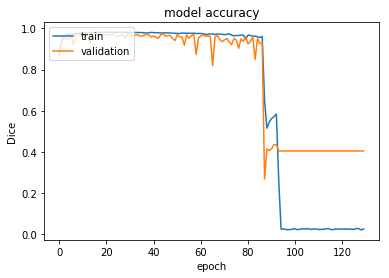

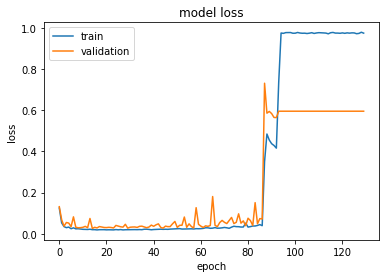

predict test data
5267/5267 [==============================] - 80s 15ms/step
array to image
Time to process --- 126532.67463064194 seconds ---


In [3]:
if __name__ == '__main__':
	start_time = time.time()
	#model_dice = dice_loss(smooth=1e-5, thresh=0.9)
	myunet = myUnet()
	myunet.train()
	myunet.save_img()
	print("Time to process --- %s seconds ---" % (time.time() - start_time))

# Evaluate 

In [1]:
imgs_test = np.load('data/npydata/test_volumes.npy')
imgs_test = imgs_test.astype('float32')
imgs_test /= 255

labels_test = np.load('data/npydata/test_labels.npy')
labels_test = labels_test.astype('float32')
labels_test /= 255



NameError: name 'np' is not defined

(5267, 128, 128, 1)


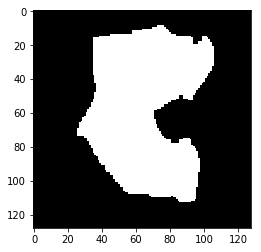

In [ ]:
my_model = load_model('axial-network-ns.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
out = my_model.evaluate(x=imgs_test, y=labels_test, batch_size=2, verbose=1, sample_weight=None, steps=None)
print(out)
print(my_model.metrics_names)

D:\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\topology.py:1271: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


# Predict

In [4]:

imgs_test = np.load('data/npydata/test_volumes.npy')
imgs_test = imgs_test.astype('float32')
imgs_test /= 255

myunet = myUnet()

model = myunet.get_unet()

model.load_weights('weights-improvement-136-0.01.hdf5')

imgs_mask_test = model.predict(imgs_test, verbose=1)

np.save('data/npydata/calculated_test_mask5.npy', imgs_mask_test)

conv1 shape: (?, 128, 128, 64)
conv1 shape: (?, 128, 128, 64)
pool1 shape: (?, 64, 64, 64)
conv2 shape: (?, 64, 64, 128)
conv2 shape: (?, 64, 64, 128)
pool2 shape: (?, 32, 32, 128)
conv3 shape: (?, 32, 32, 256)
conv3 shape: (?, 32, 32, 256)
pool3 shape: (?, 16, 16, 256)


D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:117: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
D:\Anaconda3\envs\tensorflow\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:122: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:127: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
D:\Anaconda3\envs\tensorflow\lib\site-packages\ip

OSError: Unable to open file (unable to open file: name = 'weights-improvement-136-0.01.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)